Implement GRU-based model for Sentiment Analysis

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Model hyperparameters
vocab_size = 10000
max_len = 500
embedding_dim = 128
gru_units = 64
epochs = 5
batch_size = 32



In [6]:
print("Loading IMDB dataset...")

# Load IMDB movie reviews dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")
print(f"Average review length: {np.mean([len(x) for x in x_train]):.2f}")

# Pad sequences to fixed length
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")



Loading IMDB dataset...
Training samples: 25000
Test samples: 25000
Average review length: 238.71
Training data shape: (25000, 500)
Test data shape: (25000, 500)


In [7]:
# Build GRU model
print("Building GRU model...")

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size,
                   output_dim=embedding_dim,
                   input_length=max_len,
                   name='embedding'))

# Dropout for regularization
model.add(Dropout(0.2, name='dropout_1'))

# First GRU layer with return_sequences=True for stacking
model.add(GRU(gru_units,
              return_sequences=True,
              dropout=0.2,
              recurrent_dropout=0.2,
              name='gru_1'))

# Second GRU layer
model.add(GRU(gru_units//2,
              dropout=0.2,
              recurrent_dropout=0.2,
              name='gru_2'))

# Dropout layer
model.add(Dropout(0.3, name='dropout_2'))

# Dense layer with ReLU activation
model.add(Dense(32, activation='relu', name='dense_1'))

# Final dropout
model.add(Dropout(0.2, name='dropout_3'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid', name='output'))

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)





Building GRU model...


In [8]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_gru_model.h5', save_best_only=True, monitor='val_loss')
]

print("Training model...")

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

# Evaluate the model
print("Evaluating model...")

# Make predictions on test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate test accuracy and loss
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))



Training model...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6393 - loss: 0.6075

625/625 ━━━━━━━━━━━━━━━━━━━━ 1103s 2s/step - accuracy: 0.6394 - loss: 0.6074 - val_accuracy: 0.8048 - val_loss: 0.4215
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1100s 2s/step - accuracy: 0.8447 - loss: 0.3741 - val_accuracy: 0.8064 - val_loss: 0.4539
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8809 - loss: 0.3131

625/625 ━━━━━━━━━━━━━━━━━━━━ 1107s 2s/step - accuracy: 0.8809 - loss: 0.3131 - val_accuracy: 0.8778 - val_loss: 0.3037
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9253 - loss: 0.2034

625/625 ━━━━━━━━━━━━━━━━━━━━ 1099s 2s/step - accuracy: 0.9253 - loss: 0.2033 - val_accuracy: 0.8808 - val_loss: 0.3035
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1093s 2s/step - accuracy: 0.9466 - loss: 0.1506 - val_accuracy: 0.8798 - val_loss: 0.3314
Training completed!
Evaluating model...
782/782 ━━━━━━━━━━━━━━━━━━━━ 392s 501ms/step
Test Accuracy: 0.8766
Test Loss: 0.3174

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.86      0.88     12500
    Positive       0.87      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



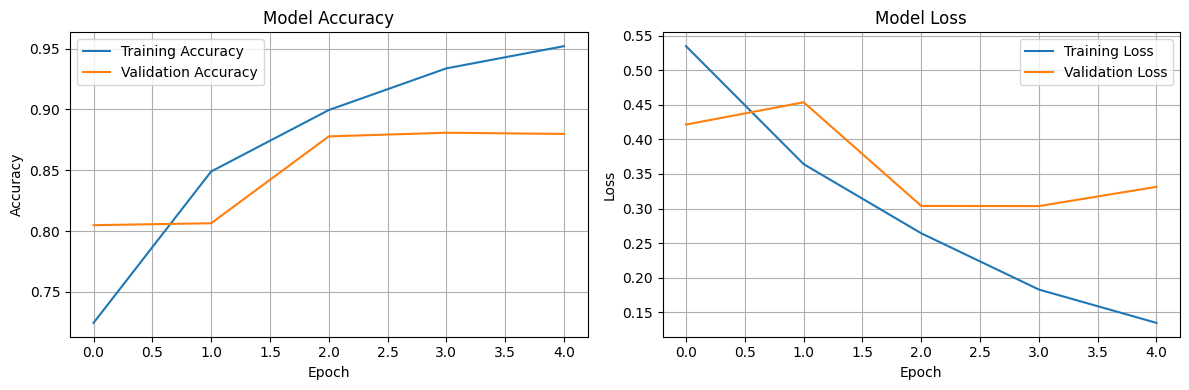

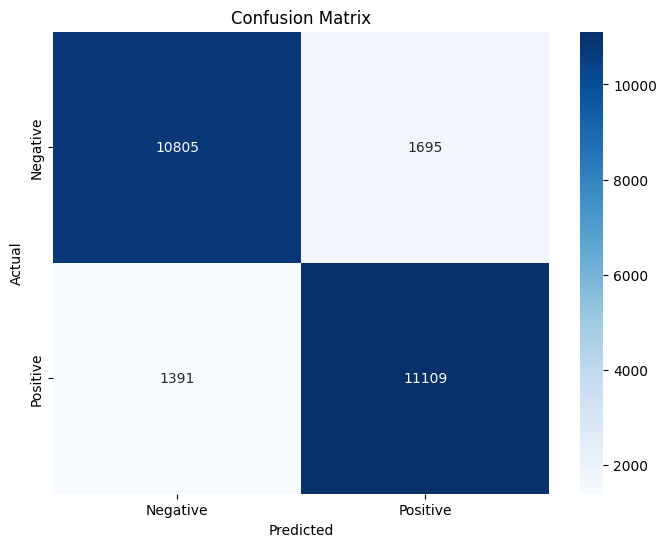

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

EXAMPLE PREDICTIONS


In [9]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Load word index for text predictions
word_index = imdb.get_word_index()

# Example text predictions
print("\n" + "="*50)
print("EXAMPLE PREDICTIONS")
print("="*50)

sample_reviews = [
    "This movie was absolutely fantastic! Great acting and amazing story.",
    "Terrible movie, boring plot and bad acting. Complete waste of time.",
    "The movie was okay, nothing special but not terrible either."
]



In [10]:
# Process each sample review
for review in sample_reviews:
    # Preprocess text
    words = review.lower().split()
    sequence_data = [word_index.get(word, 0) for word in words]
    sequence_data = [w for w in sequence_data if w < vocab_size]

    # Pad sequence
    padded_sequence = sequence.pad_sequences([sequence_data], maxlen=max_len)

    # Make prediction
    prob = model.predict(padded_sequence)[0][0]
    sentiment = "Positive" if prob > 0.5 else "Negative"
    confidence = prob if prob > 0.5 else 1 - prob

    print(f"Review: '{review}'")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.3f})")
    print("-" * 50)

# Display some statistics
print("\nModel Statistics:")
print(f"Total parameters: {model.count_params():,}")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Maximum sequence length: {max_len}")
print(f"Embedding dimensions: {embedding_dim}")
print(f"GRU units: {gru_units}")

# Show sample of training data (decoded)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

print("\nSample training review (decoded):")
sample_idx = 0
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[sample_idx]])
print(f"Review: {decoded_review[:200]}...")
print(f"Label: {'Positive' if y_train[sample_idx] == 1 else 'Negative'}")

print("\nModel training and evaluation completed!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
Review: 'This movie was absolutely fantastic! Great acting and amazing story.'
Predicted Sentiment: Negative (Confidence: 0.716)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
Review: 'Terrible movie, boring plot and bad acting. Complete waste of time.'
Predicted Sentiment: Negative (Confidence: 0.606)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Review: 'The movie was okay, nothing special but not terrible either.'
Predicted Sentiment: Negative (Confidence: 0.661)
--------------------------------------------------

Model Statistics:
Total parameters: 1,327,745
Vocabulary size: 10,000
Maximum sequence length: 500
Embedding dimensions: 128
GRU units: 64

Sample training review (decoded):
Review: ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?